## Changes On Tweet Day

Ziel: 
1. Ich möchte mir anschauen wie sich der DogeCoin täglich pozentual verändert, sprich der prozentuale Unterschied zwischen dem Close Werte des Vortages im Vergleich zum Close Wert des folge Tages
2. Im Anschluss möchte ich wie die tägliche Veränderung war an Tagen an dem Musk twitterte
3. Dannach möchte ich überlegen, ob man mit einer Simulation zeigen kann, dass an Tagen an den Musk Tweete der tägliche Wert signifikant sich veränderte

### 1. Tägliche Veränderung zum Vortag

In [497]:
import pandas as pd
df_dog = pd.read_csv("../dat/crypto-stocks/doge-coin-daily.csv")

# Check that date order is right
df_dog.Date = pd.to_datetime(df_dog.Date)
df_dog = df_dog.sort_values("Date")

day_shift = 1

##### Problem beim vergleich von Zeitreihen, veränderungen sind später deutlich größer

In [498]:
df_dog["Daily Changes"] = (df_dog.Close - df_dog.Close.shift(day_shift))

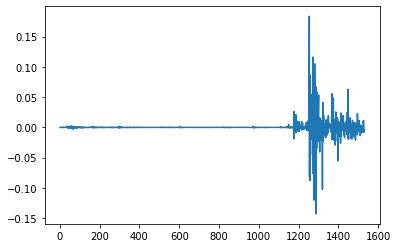

In [500]:
import matplotlib.pyplot as plt
plt.plot(df_dog["Daily Changes"])
plt.show()

##### Lösung: Standardisierung mit relation zum Vortagswert

In [501]:
df_dog["Daily Changes (%)"] = (df_dog.Close - df_dog.Close.shift(day_shift)) / df_dog.Close.shift(day_shift)

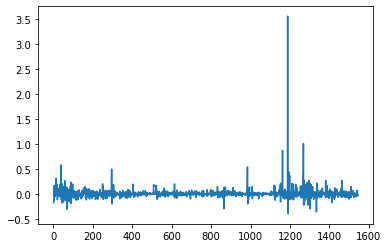

In [502]:
import matplotlib.pyplot as plt
plt.plot(data["Daily Changes (%)"])
plt.show()

##### Plot der Veränderungsverteilung

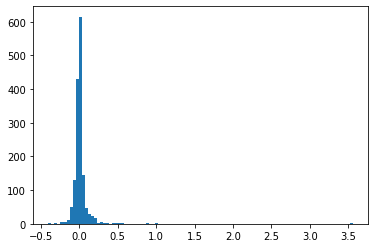

In [503]:
plt.hist(df_dog["Daily Changes (%)"], bins = 100)
plt.show()

In [504]:
round((df_dog["Daily Changes (%)"] > 0.4).mean() * 100,2) 

0.52

### 2. Fit a normal distirbution

In [470]:
from scipy.stats import norm
from scipy.optimize import minimize

param_mean = 0
param_std = 0.2
params =[param_mean, param_std]


X = df_dog["Daily Changes (%)"].values[1:]


def get_loss(params):
    p_all = []
    for i in range(len(X)):
        p = norm.pdf(X[i],loc=params[0],scale=params[1])
        p_all.append(p)
    p_all = np.array(p_all) + 0.000000001
    neg_log_like = -np.log(p_all)
    return neg_log_like.sum()  


res = minimize(get_loss, params, 
               method='TNC',
               options={'disp': True},
               bounds = ((-0.5, 0.5), (0.0005, 3)))
res

     fun: -1828.8888121966081
     jac: array([-0.00277396,  0.00461569])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 108
     nit: 7
  status: 1
 success: True
       x: array([0.00224019, 0.0660114 ])

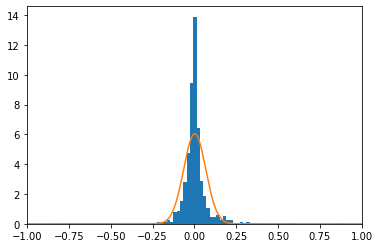

In [471]:
plt.hist(df_dog["Daily Changes (%)"], density=True,bins = 200)
x_axis = np.arange(-1, 1, 0.001)
plt.plot(x_axis, norm.pdf(x_axis,res.x[0],res.x[1]))
plt.xlim(-1,1)
plt.show()

In [472]:
from scipy.stats import laplace
from scipy.optimize import minimize

param_mean = 0
param_std = 0.2
params =[param_mean, param_std]


X = df_dog["Daily Changes (%)"].values[1:]


def get_loss(params):
    p_all = []
    for i in range(len(X)):
        p = laplace.pdf(X[i],loc=params[0],scale=params[1])
        p_all.append(p)
    p_all = np.array(p_all) + 0.000000001
    neg_log_like = -np.log(p_all)
    return neg_log_like.sum()  


res = minimize(get_loss, params, 
               method='TNC',
               options={'disp': True},
               bounds = ((-0.5, 0.5), (0.0005, 3)))
res

     fun: -2214.236166749679
     jac: array([17.23392415,  2.49528966])
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 168
     nit: 9
  status: 2
 success: True
       x: array([-0.00080418,  0.04226378])

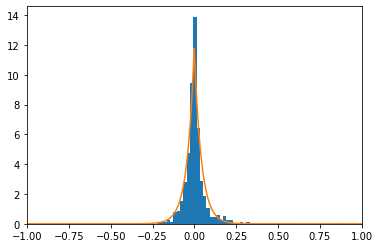

In [473]:
plt.hist(df_dog["Daily Changes (%)"], density=True,bins = 200)
x_axis = np.arange(-1, 1, 0.001)
plt.plot(x_axis, laplace.pdf(x_axis,res.x[0],res.x[1]))
plt.xlim(-1,1)
plt.show()

### 3. Tägliche Veränderung zum Vortag an Tweet Days von Musk

In [179]:
df_merged = pd.read_csv("../dat/cleaned_data/hot_tweets_merged_dataset.csv")

In [180]:
df_tweets = df_merged [~df_merged.tweet.isnull()]

In [181]:
df_only_tweets = df_tweets [df_tweets.tweet.str[0] != "@"]
tweet_dates = df_only_tweets.Date.unique()
tweet_dates

array(['2019-04-02', '2021-02-04', '2021-02-10', '2021-02-14',
       '2021-03-13'], dtype=object)

In [489]:
df_doge_at_tweets = df_dog [df_dog.Date.astype(str).isin(tweet_dates)].reset_index(drop=True)
df_doge_at_tweets["Daily Changes (%)"].values

array([ 0.13571719,  0.43558728,  0.0403311 , -0.05888638,  0.12796979])

In [495]:
x = df_doge_at_tweets["Daily Changes (%)"].values
p_under_dist = laplace.cdf(x,res.x[0],res.x[1])
p_under_dist = 1 - p_under_dist
p_under_dist [3] = 1 - p_under_dist [3]          

In [496]:
df_doge_at_tweets["p-value"] = p_under_dist
df_doge_at_tweets

,Date,Open,High,Low,Close,Volume,Daily Changes,Daily Changes (%),p-value
0,2019-04-02,0.002459,0.002863,0.002394,0.002795,60298362,0.000334,0.135717,0.019774
1,2021-02-04,0.037226,0.057869,0.035945,0.053289,13040837601,0.016169,0.435587,0.000016
2,2021-02-10,0.070111,0.081091,0.068525,0.072896,6785088422,0.002826,0.040331,0.188917
3,2021-02-14,0.066448,0.066448,0.056723,0.062537,3984667628,-0.003913,-0.058886,0.126511
4,2021-03-13,0.055353,0.062432,0.054756,0.062432,1869833076,0.007083,0.127970,0.023753


Die Analyse zeigt:
- Tage an denen Elon Musk über DogeCoin twittere veränderte sich der Kurs signifikant (nicht immer stark signifikant)
- Es gibt also einen Zusammenhang zwischen Elon Musks tweets und einer Kursveränderung am selben Tag.
- Aber nicht kausal, es lässt sich nicht klären, ob zu erst der Tweet und dann der Kursanstiegt (als möglich zeitlich dirkete folge = Kauslaität) oder ob der Tweet eine Reaktion auf den Kursansstieg war. 
- Hier für müssten sich Stundendaten angescahut werden



- Problematisch ist außerdem, dass die tägliche Veränderung bei einem Auf/Abwärtstrend mit einander korrellieren. Beispiel bei einem Tweet während eines Aufschwungs. Hier könnte die Veränderung auf den gesmat Trend zurück gehen und nicht auf den einzelen Tag.